# Torque Analysis for a 5-DOF Robotic Manipulator

# Compute Torques Due to Gravity

In [85]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [92]:

# Define the computation function
def compute_torques(
    d_1_val, d_5_val, a_2_val, a_3_val, masses, inertias, angles, external_forces
):
    # Define symbolic variables for joint angles, DH parameters, masses, and inertia
    theta_1, theta_2, theta_3, theta_4, theta_5 = sp.symbols(
        "theta_1 theta_2 theta_3 theta_4 theta_5"
    )
    d_1, d_5 = sp.symbols("d_1 d_5")
    a_2, a_3 = sp.symbols("a_2 a_3")
    alpha = [90, 0, 0, 90, 0]
    m1, m2, m3, m4, m5 = sp.symbols("m1 m2 m3 m4 m5")
    g = sp.Matrix([0, 0, -9.81])

    # Define inertia matrices (assuming simple diagonal form for simplicity)
    I1_xx, I1_yy, I1_zz = sp.symbols("I1_xx I1_yy I1_zz")
    I2_xx, I2_yy, I2_zz = sp.symbols("I2_xx I2_yy I2_zz")
    I3_xx, I3_yy, I3_zz = sp.symbols("I3_xx I3_yy I3_zz")
    I4_xx, I4_yy, I4_zz = sp.symbols("I4_xx I4_yy I4_zz")
    I5_xx, I5_yy, I5_zz = sp.symbols("I5_xx I5_yy I5_zz")

    I1 = sp.diag(I1_xx, I1_yy, I1_zz)
    I2 = sp.diag(I2_xx, I2_yy, I2_zz)
    I3 = sp.diag(I3_xx, I3_yy, I3_zz)
    I4 = sp.diag(I4_xx, I4_yy, I4_zz)
    I5 = sp.diag(I5_xx, I5_yy, I5_zz)

    # Helper function to create a transformation matrix from DH parameters
    def dh_matrix(theta, d, a, alpha):
        alpha_rad = sp.rad(alpha)
        return sp.Matrix(
            [
                [
                    sp.cos(theta),
                    -sp.sin(theta) * sp.cos(alpha_rad),
                    sp.sin(theta) * sp.sin(alpha_rad),
                    a * sp.cos(theta),
                ],
                [
                    sp.sin(theta),
                    sp.cos(theta) * sp.cos(alpha_rad),
                    -sp.cos(theta) * sp.sin(alpha_rad),
                    a * sp.sin(theta),
                ],
                [0, sp.sin(alpha_rad), sp.cos(alpha_rad), d],
                [0, 0, 0, 1],
            ]
        )

    # Create transformation matrices
    A1 = dh_matrix(theta_1, d_1, 0, alpha[0])
    A2 = dh_matrix(theta_2, 0, a_2, alpha[1])
    A3 = dh_matrix(theta_3, 0, a_3, alpha[2])
    A4 = dh_matrix(theta_4, 0, 0, alpha[3])
    A5 = dh_matrix(theta_5, d_5, 0, alpha[4])

    # Compute the individual transformation matrices
    T1 = A1
    T2 = T1 * A2
    T3 = T2 * A3
    T4 = T3 * A4
    T5 = T4 * A5

    # Extract positions of each link's center of mass
    # Assume center of mass at the middle of each link for simplicity
    p1 = T1[:3, 3] / 2
    p2 = T2[:3, 3] / 2
    p3 = T3[:3, 3] / 2
    p4 = T4[:3, 3] / 2
    p5 = T5[:3, 3] / 2

    # Compute the Jacobians for each center of mass
    Jv1 = p1.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv2 = p2.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv3 = p3.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv4 = p4.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv5 = p5.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # Compute the gravity vector for each link (assuming center of mass at the link origin)
    G1 = m1 * g
    G2 = m2 * g
    G3 = m3 * g
    G4 = m4 * g
    G5 = m5 * g

    # Compute the torques due to gravity for each link
    tau_g1 = Jv1.T * G1
    tau_g2 = Jv2.T * G2
    tau_g3 = Jv3.T * G3
    tau_g4 = Jv4.T * G4
    tau_g5 = Jv5.T * G5

    # Sum the torques due to gravity
    tau_g = tau_g1 + tau_g2 + tau_g3 + tau_g4 + tau_g5

    # Forces and moments vector at the end effector
    Fx, Fy, Fz, Mx, My, Mz = external_forces
    F_ext = sp.Matrix([Fx, Fy, Fz, Mx, My, Mz])

    # Jacobian for the end effector
    O5 = T5[:3, 3]
    Jv_ee = O5.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # The angular part of the Jacobian is given by the z-axis of the previous frames
    z0 = sp.Matrix([0, 0, 1])  # z0 axis (base frame)
    z1 = A1[:3, :3] * z0
    z2 = (A1 * A2)[:3, :3] * z0
    z3 = (A1 * A2 * A3)[:3, :3] * z0
    z4 = (A1 * A2 * A3 * A4)[:3, :3] * z0

    # Assemble the angular velocity Jacobian
    Jw = sp.Matrix.hstack(z0, z1, z2, z3, z4)

    # Combine Jv and Jw to form the full Jacobian matrix for the end effector
    J_full = sp.Matrix.vstack(Jv_ee, Jw)

    # Compute the joint torques due to external forces/moments
    tau_ext = J_full.T * F_ext

    # Total torque in equilibrium (gravitational + external)
    tau_total = tau_g - tau_ext

    # Initialize pretty printing for better output readability
    sp.init_printing(use_unicode=True)

    # Symbolic torques
    print("Symbolic Total Joint Torques in Equilibrium:")
    sp.pprint(tau_total)

    # Provide numerical values for testing
    values = {
        d_1: d_1_val,
        d_5: d_5_val,
        a_2: a_2_val,
        a_3: a_3_val,
        m1: masses[0],
        m2: masses[1],
        m3: masses[2],
        m4: masses[3],
        m5: masses[4],
        I1_xx: inertias[0][0],
        I1_yy: inertias[0][1],
        I1_zz: inertias[0][2],
        I2_xx: inertias[1][0],
        I2_yy: inertias[1][1],
        I2_zz: inertias[1][2],
        I3_xx: inertias[2][0],
        I3_yy: inertias[2][1],
        I3_zz: inertias[2][2],
        I4_xx: inertias[3][0],
        I4_yy: inertias[3][1],
        I4_zz: inertias[3][2],
        I5_xx: inertias[4][0],
        I5_yy: inertias[4][1],
        I5_zz: inertias[4][2],
        theta_1: angles[0],
        theta_2: angles[1],
        theta_3: angles[2],
        theta_4: angles[3],
        theta_5: angles[4],
        Fx: external_forces[0],
        Fy: external_forces[1],
        Fz: external_forces[2],
        Mx: external_forces[3],
        My: external_forces[4],
        Mz: external_forces[5],
    }

    # Compute numerical torques due to gravity
    numerical_torques = tau_total.subs(values)
    return numerical_torques

In [93]:


# Define parameters for the robot
d_1_val = 0.1
d_5_val = 0.1
a_2_val = 0.5
a_3_val = 0.5
masses = [1.0, 1.0, 1.0, 1.0, 1.0]
inertias = [
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
]
external_forces = [0, 0, 0, 0, 0, 0]  # No external forces/moments

# Angles to evaluate (range for theta_2)
angles_range = np.linspace(0, 120, 100)
angles_fixed = [0, 0, 0, 0]  # Fixed angles for other joints
torques_all = {i: [] for i in range(1, 6)}  # To store torques for each joint

In [96]:

# Compute torques for a range of angles for theta_2
for theta_2_val in angles_range:
    angles = [0, theta_2_val, 0, 0, 0]
    numerical_torques = compute_torques(
        d_1_val, d_5_val, a_2_val, a_3_val, masses, inertias, angles, external_forces
    )
    numerical_torques = [float(torque) for torque in numerical_torques]

    for i in range(5):
        torques_all[i + 1].append(numerical_torques[i])

Symbolic Total Joint Torques in Equilibrium:
⎡                                                                             
⎢                                                                             
⎢                               ⎛a₂⋅cos(θ₂)   a₃⋅sin(θ₂)⋅sin(θ₃)   a₃⋅cos(θ₂)⋅
⎢-4.905⋅a₂⋅m₂⋅cos(θ₂) - 9.81⋅m₃⋅⎜────────── - ────────────────── + ───────────
⎢                               ⎝    2                2                    2  
⎢                                                                             
⎢                                     ⎛  a₃⋅sin(θ₂)⋅sin(θ₃)   a₃⋅cos(θ₂)⋅cos(θ
⎢                           - 9.81⋅m₃⋅⎜- ────────────────── + ────────────────
⎢                                     ⎝          2                    2       
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣      

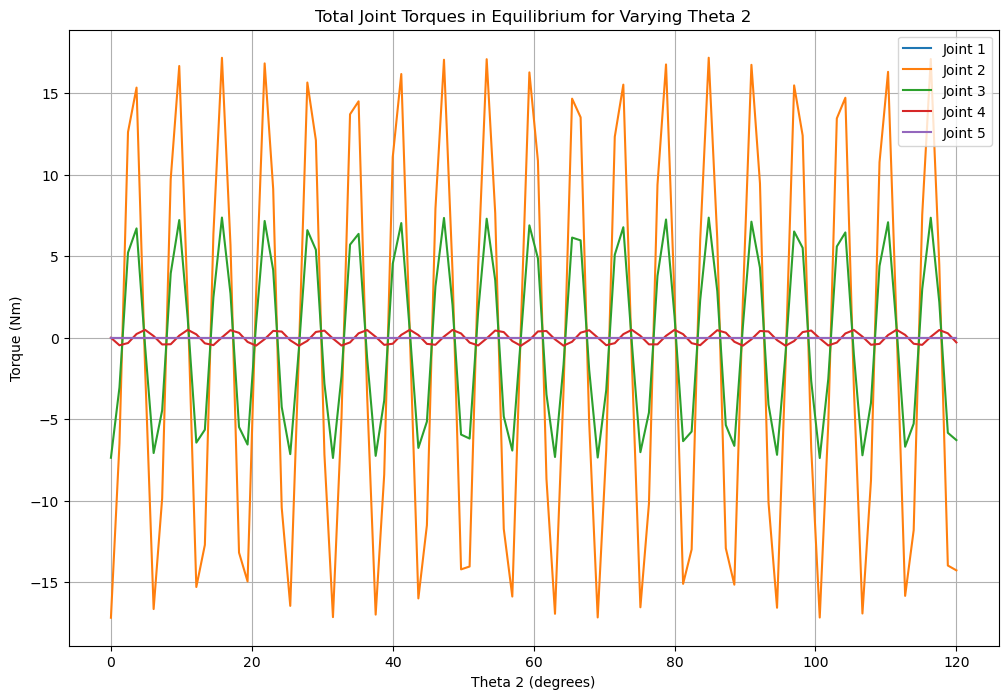

In [95]:

# Plot the torques
plt.figure(figsize=(12, 8))
for joint, torques in torques_all.items():
    plt.plot(angles_range, torques, label=f"Joint {joint}")

plt.xlabel("Theta 2 (degrees)")
plt.ylabel("Torque (Nm)")
plt.title("Total Joint Torques in Equilibrium for Varying Theta 2")
plt.legend()
plt.grid(True)
plt.show()
